# Recommender Systems Walk Through

Assumptions:

- I assume we are not recommending any brand new shows (I.e shows with no ratings)
    If this were the case we would just have to utilise CB models to deal with that.
    i.e recommend shows based on meta data of movies
    
- No brand new users. If this were the case again we would have to use meta data of movies for recommendations. 

- We use th entire customers history of movie ratings for Collab filtering. As per say the past months/week. (Simply due to not having loads of data)

Notes:

- Very difficult to evaluate these models. The best method is A/B testing but not possible for this exercise, instead we use a naive hit rate metric. 

- Eng goal is to understand Hybrid models, and to see if they perform the best.

- Each model must recommend given a users ID.

To do:

- Model based CF

- Use Directors and cost andkey words too.

In [1]:
import pandas as pd
import numpy as np 
import Utils as ut
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Clean_Item_Data')
df.drop('Unnamed: 0',inplace = True,axis = 1)

In [3]:
rating = pd.read_csv('ratings.csv')

In [4]:
rating = rating[rating.userId.isin(ut.random_sample(rating.userId.unique(),9000))]

In [5]:
rating = rating[rating.userId.map(rating.userId.value_counts())>4]

In [6]:
rating, rating_test = train_test_split(rating,
                                   stratify=rating['userId'], 
                                   test_size=0.20,
                                   random_state=432)

In [7]:
movieId_set = set.intersection(set(rating_test.movieId), 
                               set(rating.movieId), 
                               set(df.movieId))

rating_test = rating_test[rating_test.movieId.isin(movieId_set)]
rating = rating[rating.movieId.isin(movieId_set)]
df = df[df.movieId.isin(movieId_set)]

In [8]:
rating_test.shape

(130174, 4)

In [9]:
rating.shape

(515709, 4)

In [10]:
df.shape

(5150, 17)

In [11]:
df = df.reset_index(drop=True)
rating = rating.reset_index(drop=True)

In [12]:
# Very naive approach (also to do this properly I need to take into account of number of votes not just avg vote.)
user = rating.userId.sample(1).iloc[0]
ut.simple(user,df,rating,5)

,title,overview,genres,vote_average,budget,runtime,adult,vote_count,movieId,imdbId,tmdbId,cast,keywords,cast_size,crew_size,director,score
304,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",18,8.5,6000000,175.0,0,6024.0,858,68646,238,"['Marlon Brando', 'Al Pacino', 'James Caan']","['itali', 'love at first sight', 'loss of fath...",58,42,Francis Ford Coppola,8.327148
4769,Whiplash,"Under the direction of a ruthless instructor, ...",18,8.3,3300000,105.0,0,4376.0,112552,2582802,244786,"['Miles Teller', 'J.K. Simmons', 'Melissa Beno...","['jazz', 'obsess', 'conservatori', 'music teac...",51,64,Damien Chazelle,8.088796
2143,Spirited Away,A ten year old girl who wanders away from her ...,14,8.3,15000000,125.0,0,3968.0,5618,245429,129,"['Rumi Hiiragi', 'Miyu Irino', 'Mari Natsuki']","['witch', 'parent child relationship', 'magic'...",15,25,Hayao Miyazaki,8.069471
970,Life Is Beautiful,A touching story of an Italian book seller of ...,35,8.3,20000000,116.0,0,3643.0,2324,118799,637,"['Nicoletta Braschi', 'Roberto Benigni', 'Gior...","['itali', 'riddl', 'bookshop', 'self sacrific'...",23,25,Roberto Benigni,8.051348
481,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",12,8.2,18000000,124.0,0,5998.0,1196,80684,1891,"['Mark Hamill', 'Harrison Ford', 'Carrie Fisher']","['rebel', 'android', 'asteroid', 'space battl'...",76,51,Irvin Kershner,8.049156


In [13]:
ut.evaluate(rating_test, 5, 'simple', df, sample_size = 200,  rating = rating)

0.425

## Content Based Filtering 

In [14]:
df['overview_toke'] = df['overview'].apply(ut.clean_text, toke = True)

In [15]:
df['overview_clean'] = df['overview'].apply(ut.clean_text)

In [16]:
df.head(3)

,title,overview,genres,vote_average,budget,runtime,adult,vote_count,movieId,imdbId,tmdbId,cast,keywords,cast_size,crew_size,director,score,overview_toke,overview_clean
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",16,7.7,30000000,81.0,0,5415.0,1,114709,862,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,John Lasseter,7.575833,"[led, woodi, andi, toy, live, happili, hi, roo...",led woodi andi toy live happili hi room andi b...
1,Jumanji,When siblings Judy and Peter discover an encha...,12,6.9,65000000,104.0,0,2413.0,2,113497,8844,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board gam', 'disappear', ""based on children'...",26,16,Joe Johnston,6.782738,"[sibl, judi, peter, discov, enchant, board, ga...",sibl judi peter discov enchant board game open...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,10749,6.5,0,101.0,0,92.0,3,113228,15602,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fish', 'best friend', 'duringcreditssting', ...",7,4,Howard Deutch,6.252781,"[famili, wed, reignit, ancient, feud, next-doo...",famili wed reignit ancient feud next-door neig...


## TF-IDF

In [72]:
tfidf_cosine_sim = ut.TF_IDF(df['overview_clean'], ngram = 5)

In [85]:
df[df.title.str.contains("spider", case = False)]

,title,overview,genres,vote_average,budget,runtime,adult,vote_count,movieId,imdbId,tmdbId,cast,keywords,cast_size,crew_size,director,score,overview_toke,overview_clean,index1
2141,Spider-Man,After being bitten by a genetically altered sp...,14,6.8,139000000,121.0,0,5398.0,5349,145487,557,"['Tobey Maguire', 'Willem Dafoe', 'Kirsten Dun...","['loss of lov', 'spider', 'thanksgiv', 'bad bo...",71,126,Sam Raimi,6.750513,"[bitten, genet, alter, spider, nerdi, high, sc...",bitten genet alter spider nerdi high school st...,2141
2370,Spider,A mentally disturbed man takes residence in a ...,18,6.4,0,98.0,0,176.0,6197,278731,9613,"['Ralph Fiennes', 'Miranda Richardson', 'Gabri...","['secret', 'asylum', 'bed and breakfast plac',...",19,41,David Cronenberg,6.257529,"[mental, disturb, man, take, resid, halfway, h...",mental disturb man take resid halfway hous hi ...,2370
2443,Ziggy Stardust and the Spiders from Mars,Documentary from David Bowie's concert at the ...,99,7.6,0,90.0,0,15.0,6430,86643,34759,"['David Bowie', 'Mick Ronson', 'Trevor Bolder']",[],5,1,D.A. Pennebaker,6.247770,"[documentari, david, bowi, concert, hammersmit...",documentari david bowi concert hammersmith ode...,2443
2550,Kiss of the Spider Woman,Luis Molina and Valentin Arregui are cell mate...,18,6.8,0,120.0,0,53.0,6786,89424,11703,"['William Hurt', 'Raúl Juliá', 'Sônia Braga']","['gay', 'male nud', 'prison', 'based on novel'...",5,9,Hector Babenco,6.264286,"[lui, molina, valentin, arregui, cell, mate, s...",lui molina valentin arregui cell mate south am...,2550
3020,Spider-Man 2,Peter Parker is going through a major identity...,28,6.7,200000000,127.0,0,4432.0,8636,316654,558,"['Tobey Maguire', 'Kirsten Dunst', 'James Fran...","['dual ident', ""love of one's lif"", 'pizza boy...",76,128,Sam Raimi,6.650776,"[peter, parker, go, major, ident, crisi, burn,...",peter parker go major ident crisi burn spider-...,3020
4001,The Spiderwick Chronicles,Upon moving into the run-down Spiderwick Estat...,12,6.3,90000000,95.0,0,593.0,58105,416236,8204,"['Freddie Highmore', 'Mary-Louise Parker', 'Ni...","['brother sister relationship', 'family relati...",9,99,Mark Waters,6.257631,"[upon, move, run-down, spiderwick, estat, moth...",upon move run-down spiderwick estat mother twi...,4001
4717,The Amazing Spider-Man,Peter Parker is an outcast high schooler aband...,28,6.5,215000000,136.0,0,6734.0,95510,948470,1930,"['Andrew Garfield', 'Emma Stone', 'Rhys Ifans']","['loss of fath', 'vigilant', 'serum', 'marvel ...",57,106,Marc Webb,6.480051,"[peter, parker, outcast, high, schooler, aband...",peter parker outcast high schooler abandon hi ...,4717
5000,The Amazing Spider-Man 2,"For Peter Parker, life is busy. Between taking...",28,6.5,200000000,142.0,0,4274.0,110553,1872181,102382,"['Andrew Garfield', 'Emma Stone', 'Jamie Foxx']","['obsess', 'marvel com', 'sequel', 'based on c...",65,102,Marc Webb,6.469753,"[peter, parker, life, busi, take, bad, guy, sp...",peter parker life busi take bad guy spider-man...,5000


In [86]:
ut.top_rec("Spider-Man",
           tfidf_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df, 5)

4667              21 Jump Street
817           The Breakfast Club
5000    The Amazing Spider-Man 2
2837       Bang Bang You're Dead
Name: title, dtype: object

In [18]:
ut.top_rec("The Dark Knight",
           tfidf_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df, 5)

4388         The Dark Knight Rises
242                         Batman
611                 Batman Returns
4186    Batman: Under the Red Hood
Name: title, dtype: object

In [19]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = tfidf_cosine_sim)

0.015

## Word2Vec

In [20]:
word2vec_cosine_sim = ut.Word2Vec_Hybrid(
                                      df['overview_toke'], 
                                      vector_size = 300,
                                      window = 7, 
                                      epochs = 100)

100%|██████████| 18444/18444 [00:11<00:00, 1615.10it/s] 


In [21]:
ut.top_rec("The Dark Knight",
           word2vec_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4388         The Dark Knight Rises
242                         Batman
611                 Batman Returns
4186    Batman: Under the Red Hood
Name: title, dtype: object

In [22]:
word2vec_cosine_sim.shape

(5158, 5158)

In [23]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = word2vec_cosine_sim)

0.01

### Word embedding

In [24]:
doc2vec_cosine_sim = ut.Doc2Word_embed(df['overview_clean'], 
                                    df['overview_toke'], 
                                    vector_size = 300,
                                    window = 15,
                                    epochs = 100)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
ut.top_rec("The Dark Knight",
           doc2vec_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4388                     The Dark Knight Rises
242                                     Batman
4369                          Batman: Year One
2406    Remo Williams: The Adventure Begins...
Name: title, dtype: object

In [26]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = doc2vec_cosine_sim)

0.03

## Hybrid Content based model

We want to combine the NLP models (i.e TF_IDF, Word2Vec_Hybrid and Doc2Word_embed)


In [27]:
# assuming the NLP model cosine similarities are comparable we will avg

avg_nlp_sim = (word2vec_cosine_sim+tfidf_cosine_sim)/2


ut.top_rec("The Dark Knight",
           avg_nlp_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4388         The Dark Knight Rises
242                         Batman
611                 Batman Returns
4186    Batman: Under the Red Hood
Name: title, dtype: object

In [28]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = avg_nlp_sim)

0.05

In [29]:
matrix = avg_nlp_sim
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if matrix[i,j] <0:
            print("Negative")
            break

## Collaborative Filtering

### Item based

This is  collaborative filtering although we dont actually map users here. We just find the cosine similarity between movie rating vectors.

i.e If a lot of people who are highly rating to MasterChef are also highly rating Bake Off, these 2 shows will have a high similarity score.

In [14]:
df['index1'] = df.index
new = pd.merge(rating,
               df[["title", 'index1', "movieId"]], 
               how='inner',
               left_on="movieId",
               right_on="movieId")

new = new[["userId","index1","rating"]]
x = pd.pivot_table(new, values='rating', index=['index1'], columns=['userId'], aggfunc=np.max, fill_value=0) 
new.head(2)

,userId,index1,rating
0,194993,36,4.0
1,106737,36,4.0


In [52]:
item_cosine_sim = ut.Rating2Vec(x)

In [32]:
ut.top_rec("Terminator 2: Judgment Day",
           item_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

195     Jurassic Park
519    The Terminator
165             Speed
187      The Fugitive
Name: title, dtype: object

In [33]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = item_cosine_sim)

0.26

### User based

In [59]:
user_cosine_sim = ut.Rating2Vec(x.T)

In [60]:
indexes = pd.DataFrame(x.T.index)

In [61]:
ut.top_rec_user(rating.userId[0], user_cosine_sim, 10,5,df, x.T,indexes).title

2960    Harry Potter and the Prisoner of Azkaban
4033                                    Iron Man
1790                                       Shrek
496                           Return of the Jedi
5160                Star Wars: The Force Awakens
Name: title, dtype: object

In [62]:
ut.evaluate(rating_test, 5, 'UB', df, sample_size = 200, rating = rating, sim = user_cosine_sim, user_matrix = x.T, indexes = indexes, k = 10)

0.145

## Hybrid Collab & Conent model

In [38]:
combined_sim = np.multiply(item_cosine_sim, avg_nlp_sim)

In [39]:
title = df.title.sample(1).iloc[0]

print("Tile wtached: ", title)

print("Movie recommendations")
ut.top_rec(title,
           combined_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

Tile wtached:  Much Ado About Nothing
Movie recommendations


156    Four Weddings and a Funeral
737             The Wedding Singer
111       Like Water for Chocolate
36                     The Postman
Name: title, dtype: object

In [40]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = combined_sim)

0.195

In [41]:
from sklearn.preprocessing import normalize
combined_sim2 = np.divide(np.add(item_cosine_sim*2, avg_nlp_sim),2)
combined_sim2 = normalize(combined_sim2, axis=1, norm='l1')

In [42]:
ut.top_rec("Terminator 2: Judgment Day",
           combined_sim2, 
           pd.Series(df.index, index=df['title']), 
           df,5)

519    The Terminator
195     Jurassic Park
166         True Lies
165             Speed
Name: title, dtype: object

In [43]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = combined_sim2)

0.16

In [44]:
scores = np.matmul(x.T, combined_sim2)

In [45]:
ut.CB_CF_MEMORY_HYBRID_REC(scores , rating.userId[0], df, 5)

,title,movieId
549,Back to the Future,1270
544,Groundhog Day,1265
434,E.T. the Extra-Terrestrial,1097
712,The Truman Show,1682
155,Forrest Gump,356


In [46]:
ut.evaluate(rating_test, 5, 'Hybrid', df, sample_size = 200, user_movie = scores)

0.065

### Model based

#### SVD

In [20]:
from surprise import Reader, Dataset, SVD

In [32]:
x.head(2)

userId,47,80,89,90,102,107,127,131,150,201,...,270641,270674,270685,270688,270718,270719,270729,270736,270848,270894
index1,,,,,,,,,,,,,,,,,,,,,
0,0.0,0,0,0.0,0.0,0,0,0,4,4.5,...,0.0,0,0,0.0,0,0,0,0.0,0.0,0.0
1,0.0,0,0,0.0,0.0,0,0,0,0,0.0,...,0.0,0,0,0.0,0,0,0,0.0,0.0,0.0


In [64]:
from scipy.sparse.linalg import svds
M = x.T
U, sigma, Vt = svds(M, k =150)

In [65]:
sigma_diag_matrix = np.diag(sigma)

In [66]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = M.columns, index=M.index)

In [67]:
preds_df

index1,0,1,2,3,4,5,6,7,8,9,...,5459,5460,5461,5462,5463,5464,5465,5466,5467,5468
userId,,,,,,,,,,,,,,,,,,,,,
47,0.206890,-0.084963,0.226051,0.275886,-0.065360,0.344545,-0.443070,0.426263,0.352360,6.041230,...,-0.031172,-0.025064,0.028588,0.004298,0.009962,0.063335,0.002214,0.098241,-0.026274,0.003710
80,0.090107,0.188953,-0.219534,0.416049,4.384805,0.736280,-0.033869,-0.037168,0.291702,0.085258,...,0.011065,0.007162,0.003098,0.001978,-0.010329,0.040640,0.001263,0.002258,-0.006294,0.000246
89,0.033644,-0.367754,-0.227612,-0.044297,-0.220981,-0.590141,0.067733,0.047287,0.576854,0.014218,...,-0.027074,-0.018429,-0.045219,-0.000608,-0.031837,0.113323,-0.148709,0.004298,-0.050884,0.000297
90,-0.091386,0.063128,0.177861,0.031419,-0.017055,-0.096234,-0.026647,-0.037875,0.209395,-0.010165,...,0.007329,-0.010749,-0.009444,-0.001855,-0.016785,-0.004429,-0.005432,0.002929,-0.001332,0.000460
102,-0.017500,-0.050120,-0.059742,0.165551,0.093606,-0.157325,-0.020486,0.013692,-0.036205,0.067421,...,-0.012737,0.000189,0.034035,0.008510,0.012160,-0.015185,-0.016565,-0.006447,-0.006688,-0.000257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270719,0.071621,0.194067,0.104578,0.008986,0.315960,-0.000330,0.006396,-0.019401,-0.143088,0.029776,...,0.005657,0.004282,-0.017193,-0.001938,-0.008488,-0.006809,-0.002854,-0.008224,0.000058,0.000003
270729,-0.127308,0.007736,0.323470,0.334567,0.764410,0.056092,-0.027744,0.334242,0.798346,-0.103513,...,0.015841,0.015080,-0.006487,-0.001503,-0.021646,-0.015089,0.018839,-0.000969,0.004803,0.000778
270736,-0.071442,0.194331,-0.181691,-0.084906,0.190892,-0.177154,0.084736,-0.032094,-0.329955,-0.035208,...,-0.032269,0.006759,-0.031083,-0.002315,-0.016456,0.008624,0.003902,-0.014177,0.018448,0.000243


In [68]:
user_cosine_sim = ut.Rating2Vec(preds_df)

In [69]:
indexes = pd.DataFrame(preds_df.index)

In [70]:
ut.top_rec_user(rating.userId[0], user_cosine_sim, 10,5,df, x.T,indexes).title

2960    Harry Potter and the Prisoner of Azkaban
4217                                          Up
2425                                Finding Nemo
1790                                       Shrek
726                            Good Will Hunting
Name: title, dtype: object

In [71]:
ut.evaluate(rating_test, 5, 'UB', df, sample_size = 200, rating = rating, sim = user_cosine_sim, user_matrix = preds_df, indexes = indexes, k = 10)

0.17

## Neural Network

Same dataset however I have to clean slightly differently due to NN

In [1]:
# Products
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)
dtf_products = pd.read_excel("data_movies.xlsx", sheet_name="products")

dtf_products = dtf_products[~dtf_products["genres"].isna()]
dtf_products["product"] = range(0,len(dtf_products))
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["date"] = dtf_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) 
                                                             if "(" in x else np.nan)

## add features
dtf_products["date"] = dtf_products["date"].fillna(9999)
dtf_products["old"] = dtf_products["date"].apply(lambda x: 1 if x < 2000 else 0)

dtf_products

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9736,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9737,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9738,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9739,Bungo Stray Dogs: Dead Apple,2018.0,0


In [2]:
# Users

dtf_users = pd.read_excel("data_movies.xlsx", sheet_name="users").head(10000)

dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)

dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")
dtf_users = dtf_users.rename(columns={"rating":"y"})

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
9995,66,248,3.0,2005-04-11 03:41:32,65,0,0,212
9996,66,255,0.5,2005-04-11 03:07:20,65,0,0,219
9997,66,260,2.5,2004-08-29 02:45:50,65,0,1,224
9998,66,272,3.5,2005-04-11 03:31:59,65,0,0,234


In [3]:
# select only useful columns
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
tags = [i.split("|") for i in dtf_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))
columns.remove('(no genres listed)')
print(columns)

for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()
dtf_products.head()

['Adventure', 'IMAX', 'Crime', 'Comedy', 'Drama', 'Documentary', 'Horror', 'Action', 'War', 'Musical', 'Film-Noir', 'Children', 'Mystery', 'Romance', 'Animation', 'Thriller', 'Fantasy', 'Western', 'Sci-Fi']


,name,old,genres,Adventure,IMAX,Crime,Comedy,Drama,Documentary,Horror,...,Musical,Film-Noir,Children,Mystery,Romance,Animation,Thriller,Fantasy,Western,Sci-Fi
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,Jumanji,1,Adventure|Children|Fantasy,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,Father of the Bride Part II,1,Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# extract context
dtf_context = dtf_users[["user","product","daytime","weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [5]:
dtf_users = dtf_users[["user","product","y"]]
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]

dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), 
                         columns=dtf_users.columns, index=dtf_users.index)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,0.8,NaN,0.750,NaN,NaN,0.750,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,0.833333,NaN,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,0.8,NaN,0.625,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
split = int(0.8*dtf_users.shape[1])
split

# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 9329
non-null data: 671


product,7792,7793,7794,7795,7796,7797,7798,7799,7800,7801,...,9731,9732,9733,9734,9735,9736,9737,9738,9739,9740
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.80
1,0,2,0.75
2,0,5,0.75
3,0,43,1.00
4,0,46,1.00


In [8]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.800000
4,1,8509,0.500000


In [9]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_xusers_emb (Embedding)       (None, 1, 50)        3300        xusers_in[0][0]                  
__________________________________________________________________________________________________
nn_xproducts_emb (Embedding)    (None, 1, 50)        487050      xproducts_in[0][0]               
______________________________________________________________________

2022-06-26 10:43:40.302524: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2022-06-26 10:43:40.303600: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56455e993500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-26 10:43:40.303627: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-26 10:43:40.304198: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


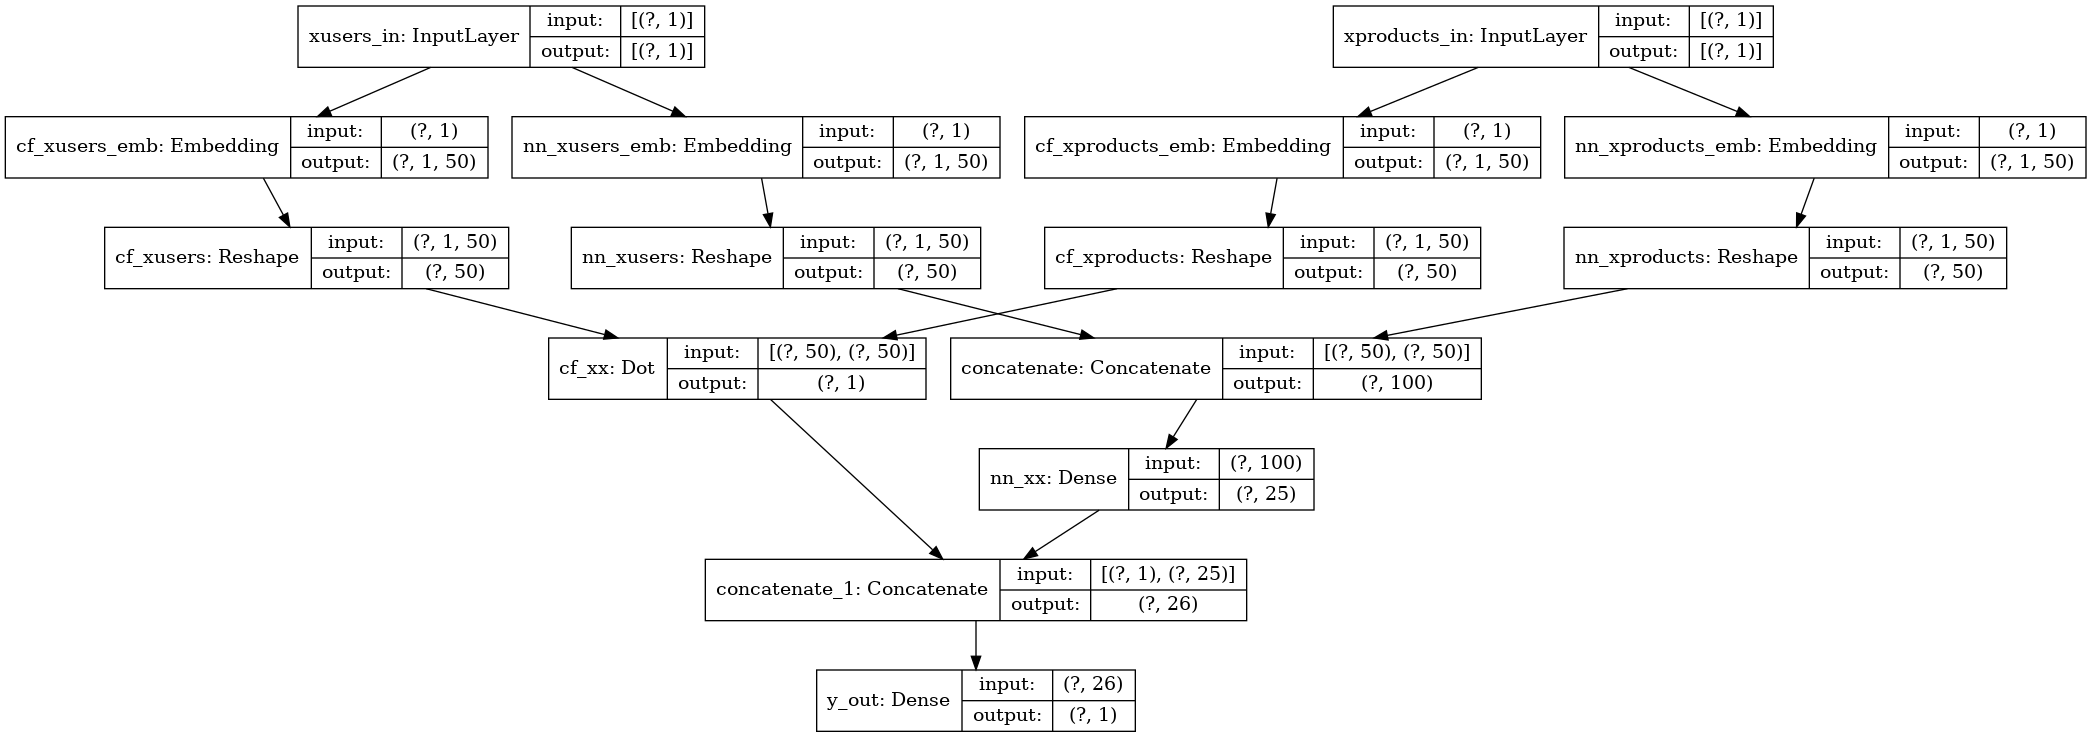

In [10]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

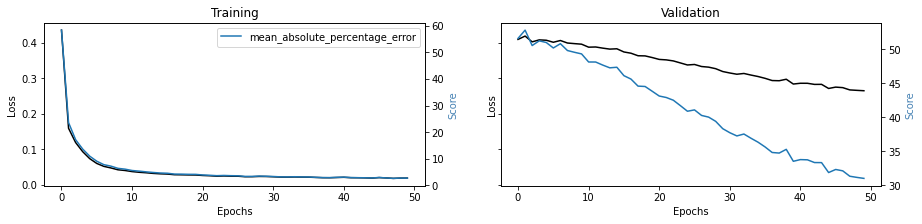

In [12]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=50, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [13]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

,user,product,y,yhat
0,1,8063,0.812500,0.593796
1,1,8305,1.000000,0.789849
2,1,8376,0.777778,0.635177
3,1,8466,0.800000,0.655066
4,1,8509,0.500000,0.694344
...,...,...,...,...
666,64,8023,0.500000,0.445640
667,64,8376,0.944444,0.507647
668,64,8438,0.666667,0.446164
669,64,8569,0.900000,0.320322


In [14]:
# overall
y_test = test["y"]
predicted = test["yhat"]

In [31]:
test.user.unique()

array([ 1,  9, 14, 17, 20, 23, 24, 28, 29, 40, 46, 48, 49, 51, 61, 62, 64])

In [43]:
def NN_Test(test,n = 5):
    tp = 0
    
    for user in range(test.user.nunique()):
        top = n
        y_test = test[test["user"]==user].sort_values("y", ascending=False)["product"].values[:top]

        predicted = test[test["user"]==user].sort_values("yhat", ascending=False)["product"].values[:top]
        
        tp += len(list(set(y_test) & set(predicted)))
    
    return tp/test.user.nunique()


In [45]:
NN_Test(test)

0.23529411764705882

## Full Hybrid Neural Network

### This model takes into account:

    - Product features — tags and descriptions of the items (i.e. movie genres), mostly used in the Content-Based methods.

    - User profile — descriptive information about users can be demographics (i.e. gender and age) or behavioral (i.e. preferences, average time on screen, most frequent time of usage), mostly used for Knowledge-Based recommendations.

    - Context — additional information regarding the situation around the rating (i.e. when, where, search history), often included in Knowledge-Based recommendations as well.

In [35]:
# Extra data
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'Adventure', 'IMAX', 'Crime', 'Comedy', 'Drama', 'Documentary',
       'Horror', 'Action', 'War', 'Musical', 'Film-Noir', 'Children',
       'Mystery', 'Romance', 'Animation', 'Thriller', 'Fantasy', 'Western',
       'Sci-Fi'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [36]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,Adventure,IMAX,Crime,Comedy,Drama,Documentary,...,Children,Mystery,Romance,Animation,Thriller,Fantasy,Western,Sci-Fi,daytime,weekend
0,0,0,0.80,1,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,1
1,0,2,0.75,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,5,0.75,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1
3,0,43,1.00,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,1
4,0,46,1.00,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,1


In [37]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

,user,product,y,old,Adventure,IMAX,Crime,Comedy,Drama,Documentary,...,Children,Mystery,Romance,Animation,Thriller,Fantasy,Western,Sci-Fi,daytime,weekend
0,1,8063,0.812500,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,8305,1.000000,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,8376,0.777778,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,8466,0.800000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,8509,0.500000,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [38]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_xusers_emb (Embedding)       (None, 1, 50)        3300        xusers_in[0][0]                  
__________________________________________________________________________________________________
nn_xproducts_emb (Embedding)    (None, 1, 50)        487050      xproducts_in[0][0]               
_______________________________________________________________________________________

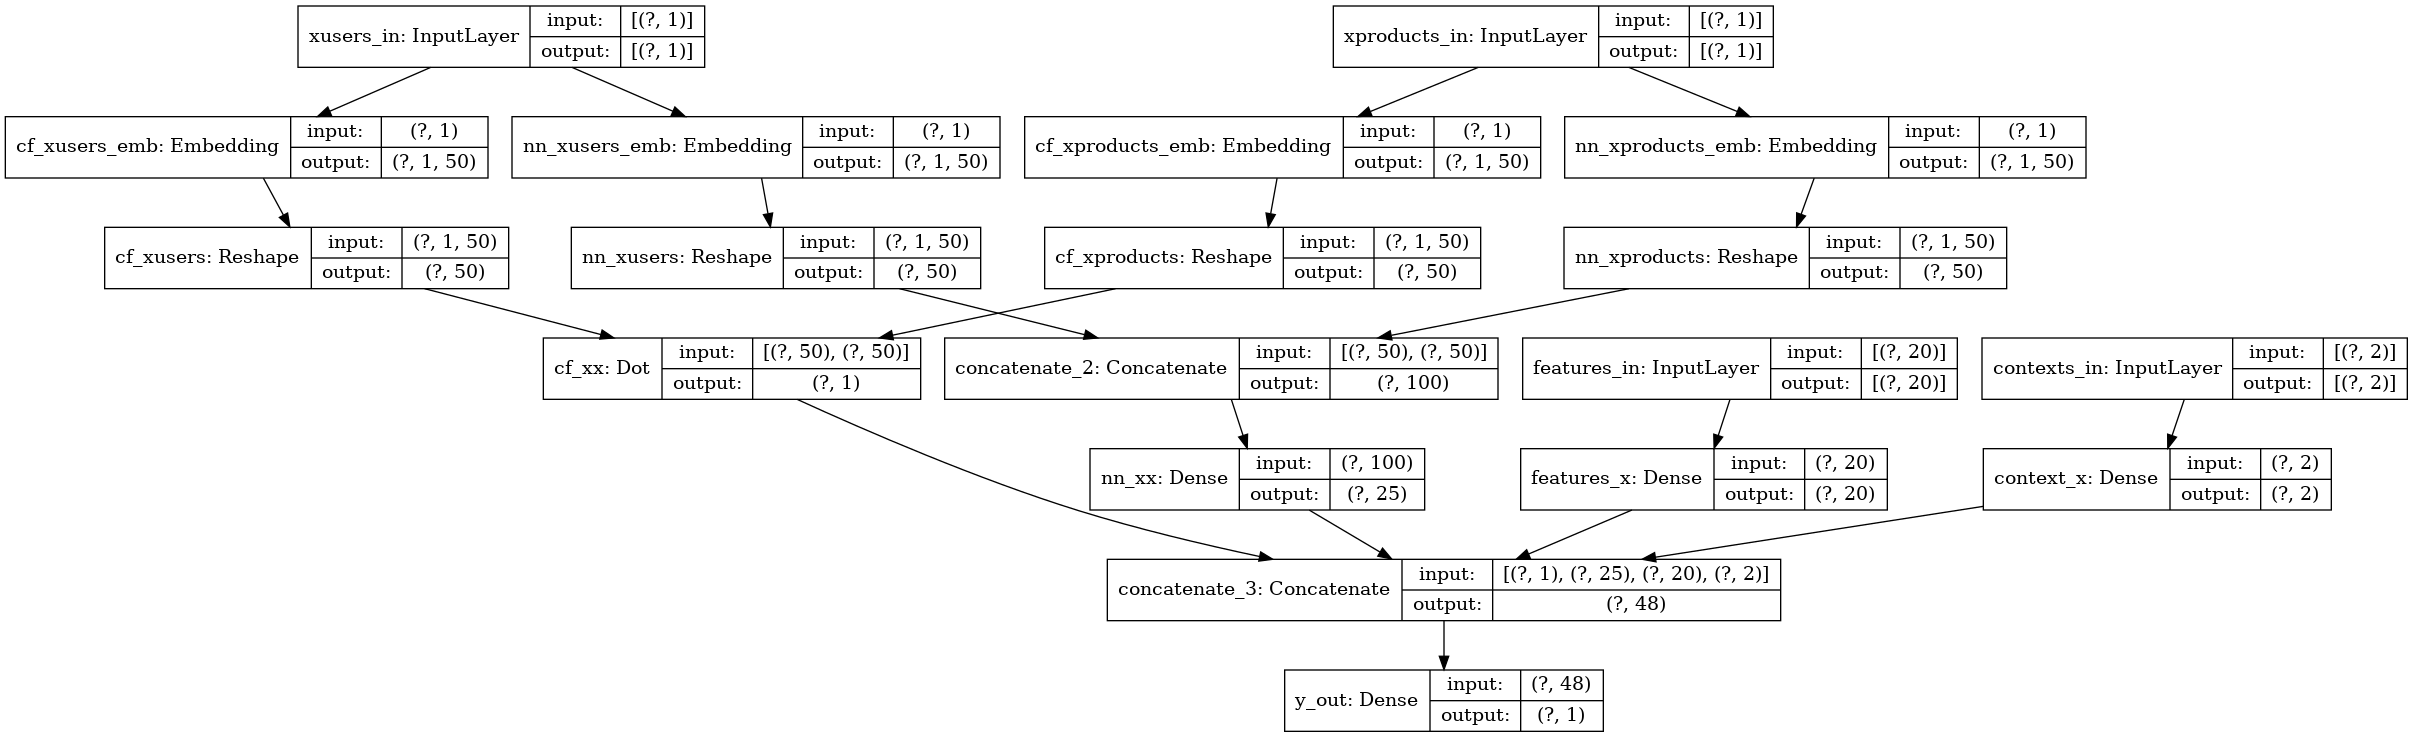

In [39]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [40]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

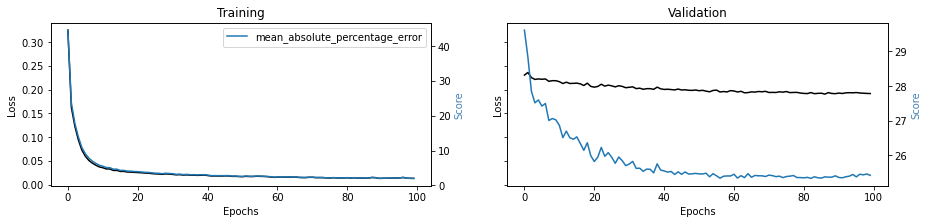

In [41]:
model = training.model
utils_plot_keras_training(training)

In [42]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

,user,product,y,old,Adventure,IMAX,Crime,Comedy,Drama,Documentary,...,Mystery,Romance,Animation,Thriller,Fantasy,Western,Sci-Fi,daytime,weekend,yhat
0,1,8063,0.812500,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0.629955
1,1,8305,1.000000,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0.645358
2,1,8376,0.777778,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.335793
3,1,8466,0.800000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.588272
4,1,8509,0.500000,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0.658050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,64,8023,0.500000,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0.649786
667,64,8376,0.944444,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.495844
668,64,8438,0.666667,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.448637
669,64,8569,0.900000,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.569205


In [44]:
NN_Test(test)

0.23529411764705882

## Evaluation

Very difficult to evaluate, here we use a hit rate. However there are issues doing this and it doesnt exactly represent the power/useful ness of each model.

In [ ]:
UB = ut.evaluate(rating_test, 5, 'UB', df, sample_size = 200, rating = rating, sim = user_cosine_sim, user_matrix = x.T, indexes = indexes, k = 10)
IB = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = item_cosine_sim)
Hybrid_cb = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = avg_nlp_sim)
d2v = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = doc2vec_cosine_sim)
w2v = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = word2vec_cosine_sim)
tf = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = tfidf_cosine_sim)
simp = ut.evaluate(rating_test, 5, 'simple', df,  rating = rating)
h1 = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = combined_sim)
h2 = ut.evaluate(rating_test, 5, 'CB', df, sample_size = 200, sim = combined_sim2)
h3 = ut.evaluate(rating_test, 5, 'Hybrid', df, sample_size = 200, user_movie = scores)

to do:
- Evaluation method
- Finish simple memory based collab
- do a model based one

look into how a neural network could combine evrything.

Hybrid

Factorisation machines?
